In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import lightgbm as lgb
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.wrappers.scikit_learn import KerasRegressor
from keras import layers
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

#load data:
df = pd.read_csv("ecfp4_descriptors_10000.csv")
df

Using TensorFlow backend.


,rt,0,1,2,3,4,5,6,7,8,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,93.5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,687.8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,590.7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,583.6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,579.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,101.8,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9996,865.5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,685.4,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
9998,1015.1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [2]:
#Split dataframe:
x_train, x_valid, y_train, y_valid= train_test_split(df.iloc[:,1:], df.iloc[:, 0], test_size=0.25, shuffle=True,random_state=0)

#fit lasso:
lasso_reg = SGDRegressor(penalty="l2")
lasso_model = lasso_reg.fit(x_train, y_train)

#fit random forest
rf = RandomForestRegressor(n_estimators=100) #just use 1000-1500 possible
rf_model = rf.fit(x_train, y_train)

#fit gbdt
#Optimize on validation data: 
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_valid, y_valid, reference=lgb_train)

#Set params
params ={
        'boosting_type': 'gbdt',
        'objective': 'mean_squared_error',
        'metric': 'rmse',
        'lambda_l1': 0.00092,
        'lambda_l2': 4.07e-08,
        'num_leaves': 240,
        'feature_fraction': 0.98,
        'bagging_fraction': 0.93,
        'bagging_freq': 4,
        'min_child_samples': 20,
        'verbose':0
        }

#Set Early Stopping
gb_model = lgb.train(params,
                lgb_train,
                num_boost_round=300,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)
                
#Fit Neural Network
def baseline_model():
    model = Sequential()
    model.add(Dense(500, kernel_initializer='normal', use_bias=False, input_shape=(2048,)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(Dropout(0.4))
    model.add(Dense(200, kernel_initializer='normal', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(Dropout(0.4))
    model.add(Dense(100, kernel_initializer='normal', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(Dense(1))
    model.summary()
    model.compile(loss='mean_squared_error',
              optimizer='RMSprop')
    return model

#Set early stopping
es = EarlyStopping(monitor='val_loss', mode='min', patience=4, verbose=1)

nn_model = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=200, verbose=True,  validation_data=(x_valid, y_valid), callbacks=[es])
nn_model.fit(x_train, y_train)

[1]	valid_0's rmse: 212.975
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 205.197
[3]	valid_0's rmse: 198.951
[4]	valid_0's rmse: 193.267
[5]	valid_0's rmse: 188.409
[6]	valid_0's rmse: 184.445
[7]	valid_0's rmse: 181.082
[8]	valid_0's rmse: 177.709
[9]	valid_0's rmse: 174.684
[10]	valid_0's rmse: 172.04
[11]	valid_0's rmse: 169.64
[12]	valid_0's rmse: 167.564
[13]	valid_0's rmse: 165.823
[14]	valid_0's rmse: 164.034
[15]	valid_0's rmse: 162.269
[16]	valid_0's rmse: 160.903
[17]	valid_0's rmse: 159.462
[18]	valid_0's rmse: 158.381
[19]	valid_0's rmse: 157.182
[20]	valid_0's rmse: 156.02
[21]	valid_0's rmse: 154.963
[22]	valid_0's rmse: 154.195
[23]	valid_0's rmse: 153.472
[24]	valid_0's rmse: 152.594
[25]	valid_0's rmse: 151.955
[26]	valid_0's rmse: 151.072
[27]	valid_0's rmse: 150.529
[28]	valid_0's rmse: 149.806
[29]	valid_0's rmse: 148.958
[30]	valid_0's rmse: 148.381
[31]	valid_0's rmse: 147.888
[32]	valid_0's rmse: 147.226
[33]	valid_0's rmse: 146

In [8]:
#Function to evaluate results
def evaluate_metrics(y, pre_y):
    return [metrics.mean_absolute_error(y, pre_y),metrics.median_absolute_error(y, pre_y),metrics.r2_score(y, pre_y), 
            metrics.mean_squared_error(y, pre_y)]

def plot_scatter(y1, py1, py2, py3, py4, title):
    
    def _plot_scatter(experimented_value, predicted_value, title):
        lim = (min(experimented_value.min(), predicted_value.min()),
               max(experimented_value.max(), predicted_value.max()))
        plt.scatter(predicted_value, experimented_value, s=3)
        plt.plot(lim, lim, c='red', alpha=0.2)
        plt.xlim(lim)
        plt.ylim(lim)
        plt.xlabel('Predicted value', fontsize=12)
        plt.ylabel('Experimental value', fontsize=12)
        plt.title(title, fontsize=12)
        
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    _plot_scatter(y1, py1,c[0])
    plt.subplot(1, 4, 2)
    _plot_scatter(y1, py2,c[1])
    plt.subplot(1, 4, 3)
    _plot_scatter(y1, py3,c[2])
    plt.subplot(1, 4, 4)
    _plot_scatter(y1, py4,c[3])

2500/2500 [==============================] - 0s 130us/step


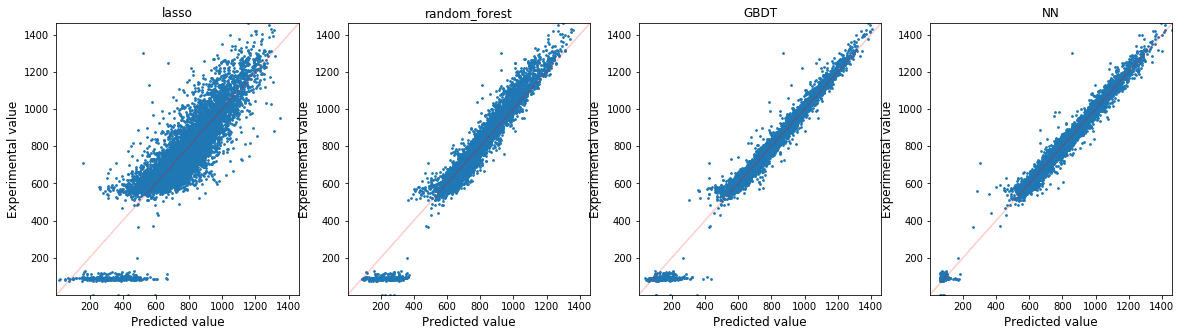

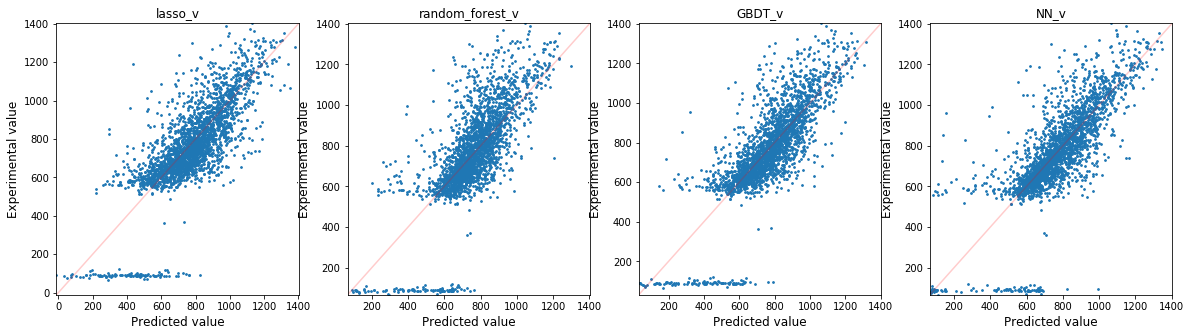

In [9]:
names = ["lasso", "random_forest", "GBDT", "NN","lasso_v", "random_forest_v", "GBDT_v", "NN_v"]
bin_metrics = []

for i, b,c in zip([x_train, x_valid,],[y_train, y_valid], [["lasso", "random_forest", "GBDT", "NN"], ["lasso_v", "random_forest_v", "GBDT_v", "NN_v"]]) :
    bin_metrics.append(evaluate_metrics(b,lasso_model.predict(i)))
    bin_metrics.append(evaluate_metrics(b,rf_model.predict(i)))
    bin_metrics.append(evaluate_metrics(b,gb_model.predict(i, num_iteration=gb_model.best_iteration)))
    bin_metrics.append(evaluate_metrics(b,nn_model.predict(i)))
    
    plot_scatter(b, lasso_model.predict(i), rf_model.predict(i),gb_model.predict(i, num_iteration=gb_model.best_iteration), nn_model.predict(i), c)

In [10]:
#Generate summary table
df2 = pd.DataFrame(bin_metrics)
df2.columns =["MAE", "MediAE", "r2", "MSE"]
df2["algo"] = names
df2.set_index('algo', inplace=True)
df2.round(decimals=2)

,MAE,MediAE,r2,MSE
algo,,,,
lasso,76.96,56.50,0.77,11455.72
random_forest,37.63,24.15,0.94,3116.20
GBDT,20.76,14.02,0.98,1068.48
NN,19.92,15.03,0.98,800.78
lasso_v,101.63,71.50,0.58,20484.99
random_forest_v,103.90,69.34,0.53,23317.40
GBDT_v,92.00,59.68,0.63,18047.39
NN_v,88.73,53.09,0.60,19566.54


In [ ]:
#Save NN model
from keras.models import load_model
from sklearn.externals import joblib

# Save the Keras model:
nn_model.model.save('XXXXXXX.h5')

# Load the Keras model:
nn_model= load_model('XXXXXXX.h5')

#Save gbm model
gb_model.save_model('lgbm_model.txt')

#load gbm model
gbm = lgb.Booster(model_file='lgbm_model.txt')
#bgm_y__test_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)
#bgm_x__train_pred = gbm.predict(x_train, num_iteration=gbm.best_iteration)

#Save rf model
import joblib
joblib.dump(rf_model, 'random_forest_nestimator100.pkl')

#load rf model
rf_model = joblib.load('rt_random_forest_nestimator100.pkl')